### Inventory Preprocessing

In [1]:
import pandas as pd

# File paths
file_2023 = "Inventory Transaction Data 2023 v0.1.xlsx"

# Load Excel files
xls_2023 = pd.ExcelFile(file_2023)


# Skip first 2 rows and drop empty columns
df_2023 = xls_2023.parse("Inventory Trans", skiprows=2)
df_2023 = df_2023.dropna(axis=1, how='all')

# Rename columns
df_2023.columns = [
    "Transaction Date", "Transaction Hour", "COMBO Indicator",
    "Combo Item", "Item Class", "VISTA Item", "No of Items", "Sell Price EA"
]

# Concatenate the two datasets (2023 first, then 2024)
merged_inventory = df_2023

# Remove rows with blank or "Overall Result" in Transaction Date
merged_inventory = merged_inventory[
    merged_inventory["Transaction Date"].notna() &
    (merged_inventory["Transaction Date"] != "Overall Result")
]



######Daily revenue csv######
# Filter rows where Transaction Hour contains "Result"
result_rows = merged_inventory[
    merged_inventory["Transaction Hour"].astype(str).str.contains("Result", case=False, na=False)
]

# Create the daily_revenue DataFrame
daily_revenue = result_rows[["Transaction Date", "Sell Price EA"]].copy()
daily_revenue.columns = ["Date", "Total Revenue"]

# Reset index for cleanliness
daily_revenue.reset_index(drop=True, inplace=True)
daily_revenue.to_csv("daily_revenue.csv", index=False)
print("Daily revenue data saved to 'daily_revenue.csv'. ✅")

###########################

# Drop rows where 'Transaction Hour' contains "Result" (string check)
merged_inventory = merged_inventory[
    ~merged_inventory["Transaction Hour"].astype(str).str.contains("Result", case=False, na=False)
]
# Convert 'Transaction Date' to datetime
merged_inventory["Transaction Date"] = pd.to_datetime(
    merged_inventory["Transaction Date"], errors="coerce", dayfirst=True
)

# Convert 'Transaction Hour' to numeric WITHOUT filling blanks
merged_inventory["Transaction Hour"] = pd.to_numeric(
    merged_inventory["Transaction Hour"], errors="coerce"
)

# Keep only rows where COMBO Indicator is not 'Y'
merged_inventory = merged_inventory[merged_inventory["COMBO Indicator"] != "Y"].copy()

###########################DAILY SESSION HOUR REVENUE#######################
# Group by Transaction Date and Transaction Hour, and sum the revenue
daily_session_hour_revenues = merged_inventory.groupby(
    ["Transaction Date", "Transaction Hour"]
)["Sell Price EA"].sum().reset_index()

# Rename columns
daily_session_hour_revenues.columns = ["Date", "Session Hour", "Total Revenue"]
# Save to CSV
daily_session_hour_revenues.to_csv("Daily_Session_Hour_Revenues.csv", index=False)
print("✅ Exported to Daily_Session_Hour_Revenues.csv")

########################Clean merged inventory##################
merged_inventory = merged_inventory.drop(columns=["COMBO Indicator"])

# Confirm it's removed
merged_inventory.to_excel("Cleaned_Merged_Inventory.xlsx", index=False)

print("Exported to Cleaned_Merged_Inventory.xlsx ✅")

Daily revenue data saved to 'daily_revenue.csv'. ✅
✅ Exported to Daily_Session_Hour_Revenues.csv
Exported to Cleaned_Merged_Inventory.xlsx ✅


### Sessions Preprocessing

In [27]:
import pandas as pd

# Load the movie sessions data
sessions_path = "Movie_sessions.xlsx"
# sessions_df = pd.read_excel(sessions_path, sheet_name="Sheet1")
# sessions_df = pd.read_excel(sessions_path)
# Option A: by name
sessions_df = pd.read_excel(
    sessions_path,
    sheet_name="Sheet1",
    engine="openpyxl"
)
# sessions_df.head()
sessions_df = sessions_df[sessions_df["Session Audio Language"] != "Overall Result"]
sessions_df = sessions_df[sessions_df["Duration"] != "960 MIN"]

# Step 1: Convert 'Duration' to numeric (strip ' MIN')
sessions_df["Duration"] = sessions_df["Duration"].str.replace(" MIN", "").astype(int)

# Create a single 'Duration Category' column based on defined ranges
sessions_df["Duration Category"] = pd.cut(
    sessions_df["Duration"],
    bins=[0, 90, 120, float('inf')],
    labels=["Short", "Medium", "Long"],
    right=False
)


# Create a function to generate all session hours based on the starting hour and duration
def get_session_hours(row):
    start_hour = int(row['Session Hour'])  # Convert start hour to integer
    duration = row['Duration']  # Duration is already in minutes
    
    # Calculate the end hour by adding duration (converted to hours) to start hour
    end_hour = start_hour + (duration // 60)  # Calculate end hour (ignoring minutes for simplicity)
    
    # Generate the list of hours the movie will run (from start hour to end hour)
    session_hours = list(range(start_hour, end_hour + 1))
    return session_hours

#Apply the function to get session hours
sessions_df['Session Hours'] = sessions_df.apply(get_session_hours, axis=1)

###################################################cleaned movie session with session hours
# Export the dataframe with the 'Session Hours' column to a CSV file
sessions_df.to_csv("Cleaned_Movie_Sessions_with_Session_Hours.csv", index=False)

print("✅ Exported the dataset to 'Cleaned_Movie_Sessions_with_Session_Hours.csv'")
##################################################

# Drop the 'Duration' column since we have the 'Session Hours' column now
sessions_df = sessions_df.drop(columns=["Duration"])


# One-hot encode categorical columns: 'Session Audio Language', 'Genre', 'Censor Rating', 'Duration Category'
dummies = pd.get_dummies(
    sessions_df[["Session Audio Language", "Genre", "Censor Rating", "Duration Category"]],
    prefix=["Lang", "Genre", "Rating", "Duration"]
)

# Convert the boolean columns to 0/1
dummies = dummies.astype(int)

# Add the one-hot encoded columns to the original dataframe
sessions_df = pd.concat([sessions_df, dummies], axis=1)

# Drop the original categorical columns after one-hot encoding
sessions_df = sessions_df.drop(columns=["Session Audio Language", "Genre", "Censor Rating", "Duration Category"])
#####################################################
sessions_df.to_csv("Cleaned_Movie_Sessions_with_Session_Hours.csv", index=False)


# Step 1: Create a function to generate the exploded dataframe based on session hours
def explode_session_hours(df):
    exploded_rows = []
    
    for _, row in df.iterrows():
        session_hours = row['Session Hours']  # Get the list of session hours for this row
        total_admits = row['Total Admits']  # Get the total admits
        one_hot_columns = row.drop(['Session Date', 'Session Hour', 'Total Admits', 'Session Hours'])  # Get the one-hot encoded columns
        
        # For each session hour in the list, create a new row
        for i, hour in enumerate(session_hours):
            # If it's the first hour, keep the total admits, otherwise set it to 0
            if i == 0:
                new_row = row.copy()  # Keep all original data for the first session hour
                new_row['Session Hour'] = hour
                exploded_rows.append(new_row)
            else:
                # For subsequent hours, set total admits and one-hot encoded columns to 0
                new_row = row.copy()
                new_row['Session Hour'] = hour
                new_row['Total Admits'] = 0
                new_row[one_hot_columns.index] = 0  # Set all one-hot columns to 0
                exploded_rows.append(new_row)
    
    # Create a new dataframe from the exploded rows
    exploded_df = pd.DataFrame(exploded_rows).reset_index(drop=True)
    return exploded_df

# Step 2: Apply the explode function to create the final dataframe
sessions_exploded_df = explode_session_hours(sessions_df)



#######################################
# Step 4: Export the exploded dataframe to CSV for later use
sessions_exploded_df.to_csv("Exploded_Sessions_with_Session_Hours.csv", index=False)

print("✅ Exported the exploded dataset to 'Exploded_Sessions_with_Session_Hours.csv'")
########################################


# Step 1: Drop the 'Session Hours' and 'Film' columns after exploding the data
sessions_exploded_df = sessions_exploded_df.drop(columns=["Session Hours", "Film"])

# Aggregate by 'Session Date' and 'Session Hour', summing the relevant columns (and all other columns)
aggregated_sessions_df = sessions_exploded_df.groupby(['Session Date', 'Session Hour']).agg(
    {col: 'sum' for col in sessions_exploded_df.columns if col not in ['Session Date', 'Session Hour']}).reset_index()


#####################################
# Step 4: Export the aggregated data to a CSV file
aggregated_sessions_df.to_csv("Aggregated_Sessions1.csv", index=False)

print("✅ Exported the aggregated dataset to 'Aggregated_Sessions1.csv'")
######################################


✅ Exported the dataset to 'Cleaned_Movie_Sessions_with_Session_Hours.csv'
✅ Exported the exploded dataset to 'Exploded_Sessions_with_Session_Hours.csv'
✅ Exported the aggregated dataset to 'Aggregated_Sessions1.csv'


### Merging code

In [29]:
# Load the daily session hour revenues data
revenue_path = "Daily_Session_Hour_Revenues.csv"
daily_session_hour_revenues = pd.read_csv(revenue_path)
# Load the Aggregated session data
aggregated_sessions_df_path = "Aggregated_Sessions1.csv"
aggregated_sessions_df= pd.read_csv(aggregated_sessions_df_path)


# Step 1: Strip leading and trailing spaces from 'Date' column
daily_session_hour_revenues['Date'] = daily_session_hour_revenues['Date'].str.strip()

# Step 2: Convert 'Date' to datetime format (YYYY-MM-DD)
daily_session_hour_revenues['Date'] = pd.to_datetime(
    daily_session_hour_revenues['Date'], 
    errors='coerce',  # Invalid dates will be set to NaT
    dayfirst=False    # Default format (YYYY-MM-DD)
)

# Convert 'Session Date' in aggregated_sessions_df to datetime (standardize format)
aggregated_sessions_df['Session Date'] = pd.to_datetime(
    aggregated_sessions_df['Session Date'], 
    format='%d.%m.%Y',  # Specify the format as dd.mm.yyyy 
    errors='coerce'
)

# Perform the left join to retain all rows from aggregated_sessions_df and match with daily_session_hour_revenues
merged_data = pd.merge(
    aggregated_sessions_df,
    daily_session_hour_revenues,
    left_on=['Session Date', 'Session Hour'],
    right_on=['Date', 'Session Hour'],
    how='left'  # Perform a left join to keep all rows from aggregated_sessions_df
)

# Replace NaN in 'Total Revenue' with 0 for unmatched rows
merged_data['Total Revenue'].fillna(0, inplace=True)

# Drop the redundant 'Date' column after the merge, since we already have 'Session Date'
merged_data = merged_data.drop(columns=['Date'])

#########################################
# Export the merged data to a CSV file for further use
merged_data.to_csv("Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv", index=False)

print("✅ Exported the merged dataset to 'Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv'")


✅ Exported the merged dataset to 'Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv'


C:\Users\Pranjal\AppData\Local\Temp\ipykernel_26396\4066960456.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Total Revenue'].fillna(0, inplace=True)


### Sales forecasting Preprocessing

In [31]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv")
# 🕒 Convert 'Session Date' to datetime
df['Session Date'] = pd.to_datetime(df['Session Date'], errors='coerce')
#######################################################################

# 🚨 Check for any conversion issues (NaT values)
conversion_issues = df[df['Session Date'].isnull()]
if not conversion_issues.empty:
    print("\n⚠️ Conversion issues found:")
    print(conversion_issues)
else:
    print("\n✅ All dates converted successfully.")

# 📆 Extract day of week and month from 'Session Date'
df['DayOfWeek'] = df['Session Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Session Date'].dt.month

#####################################for inventory forecasting part#############
# 💾 Export the updated DataFrame to CSV
df.to_csv("my_validation_data_inventory.csv", index=False)
print("✅ Data exported to 'my_validation_data_inventory.csv'")

#############################################The below line will need to be shifted below the export part in inventory forecasting part.. 
df = df.drop(columns=['Session Date'])


##################################################################
# 💾 Export the updated DataFrame to CSV
df.to_csv("my_validation_data.csv", index=False)
print("✅ Data exported to 'forecasting_data.csv'")
#################################################################




✅ All dates converted successfully.
✅ Data exported to 'my_validation_data_inventory.csv'
✅ Data exported to 'forecasting_data.csv'


### Validation with new data

In [33]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

# 1) Load your validation DataFrame
df_val = pd.read_csv("my_validation_data.csv")

# 2) Split into features & target
X_val = df_val.drop(columns=["Total Revenue"])
y_val = df_val["Total Revenue"]

# 3) Load your pickled CatBoost model and feature list
model = joblib.load("best_catboost_model.pkl")
expected_feats = joblib.load("feature_list.pkl")

# 4) Identify missing / extra features
missing_feats = [f for f in expected_feats if f not in X_val.columns]
extra_feats   = [f for f in X_val.columns if f not in expected_feats]

print(f"🔍 Missing features to ADD ({len(missing_feats)}):\n{missing_feats}")
print(f"🔍 Extra features to DROP ({len(extra_feats)}):\n{extra_feats}")

# 5) Add missing columns (zeros) and drop extras
for f in missing_feats:
    X_val[f] = 0
X_val.drop(columns=extra_feats, inplace=True)

# 6) Reorder to match training
X_val = X_val[expected_feats]
print(f"\n🔢 Aligned feature matrix shape: {X_val.shape}")

# 7) Display the newly added columns (first 5 rows)
if missing_feats:
    print("\n— Newly added (zero-filled) columns —")
    display(X_val[missing_feats].head())

# 8) Display a sample of the aligned feature matrix
print("\n— Aligned feature matrix (first 5 rows) —")
display(X_val.head())

# 9) Predict
y_pred = model.predict(X_val)

# 10) Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2   = r2_score(y_val, y_pred)
print(f"\nValidation RMSE: {rmse:.2f}, R²: {r2:.2f}")

🔍 Missing features to ADD (19):
['Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Indonesian', 'Lang_Japanese', 'Lang_Maori', 'Lang_Not assigned', 'Lang_Thai', 'Lang_Urdu', 'Genre_FAMILY', 'Genre_GAMING', 'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_SCI-FI', 'Genre_TO BE ADVISED', 'Rating_CTC']
🔍 Extra features to DROP (2):
['Lang_Spanish', 'Lang_Swedish']

🔢 Aligned feature matrix shape: (361, 56)

— Newly added (zero-filled) columns —


,Lang_Assamese,Lang_Bengali,Lang_Chinese (Cantonese),Lang_Filipino,Lang_Gujarati,Lang_Indonesian,Lang_Japanese,Lang_Maori,Lang_Not assigned,Lang_Thai,Lang_Urdu,Genre_FAMILY,Genre_GAMING,Genre_MUSIC,Genre_MUSICAL,Genre_MYSTERY,Genre_SCI-FI,Genre_TO BE ADVISED,Rating_CTC
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



— Aligned feature matrix (first 5 rows) —


,Session Hour,Total Admits,Lang_Assamese,Lang_Bengali,Lang_Chinese (Cantonese),Lang_Chinese (Mandarin),Lang_English,Lang_Filipino,Lang_Gujarati,Lang_Hindi,...,Rating_G,Rating_M,Rating_MA15,Rating_PG,Rating_R18+,Duration_Short,Duration_Medium,Duration_Long,DayOfWeek,Month
0,9,7,0,0,0,0,2,0,0,0,...,2,0,0,0,0,2,0,0,5,2
1,10,9,0,0,0,0,2,0,0,0,...,0,0,2,1,0,0,2,1,5,2
2,11,23,0,0,0,0,3,0,0,0,...,0,1,0,3,0,0,3,1,5,2
3,12,27,0,0,0,0,5,0,0,1,...,1,1,1,3,0,1,4,1,5,2
4,13,68,0,0,0,0,4,0,0,0,...,0,2,2,2,0,0,4,2,5,2



Validation RMSE: 97.55, R²: 0.63


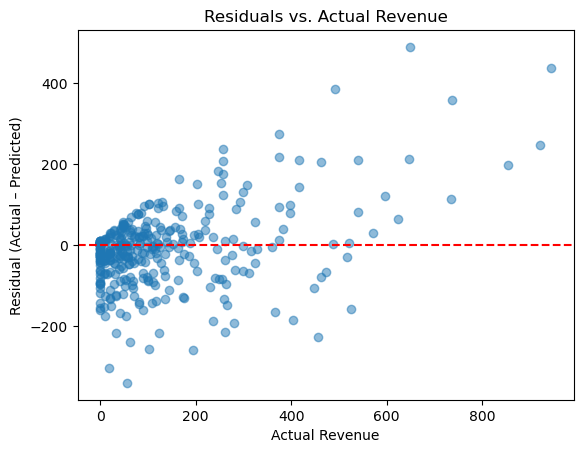

In [35]:
import matplotlib.pyplot as plt
residuals = y_val - y_pred
plt.scatter(y_val, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Residual (Actual – Predicted)")
plt.title("Residuals vs. Actual Revenue")
plt.show()


In [37]:
# 11) Save Actual vs Predicted to CSV
comparison_df = pd.DataFrame({
    "Actual Revenue":    y_val.values,
    "Predicted Revenue": y_pred
})
comparison_df.to_csv("validation_comparison.csv", index=False)
print("✅ Saved Actual vs Predicted to 'validation_comparison.csv'")


✅ Saved Actual vs Predicted to 'validation_comparison.csv'


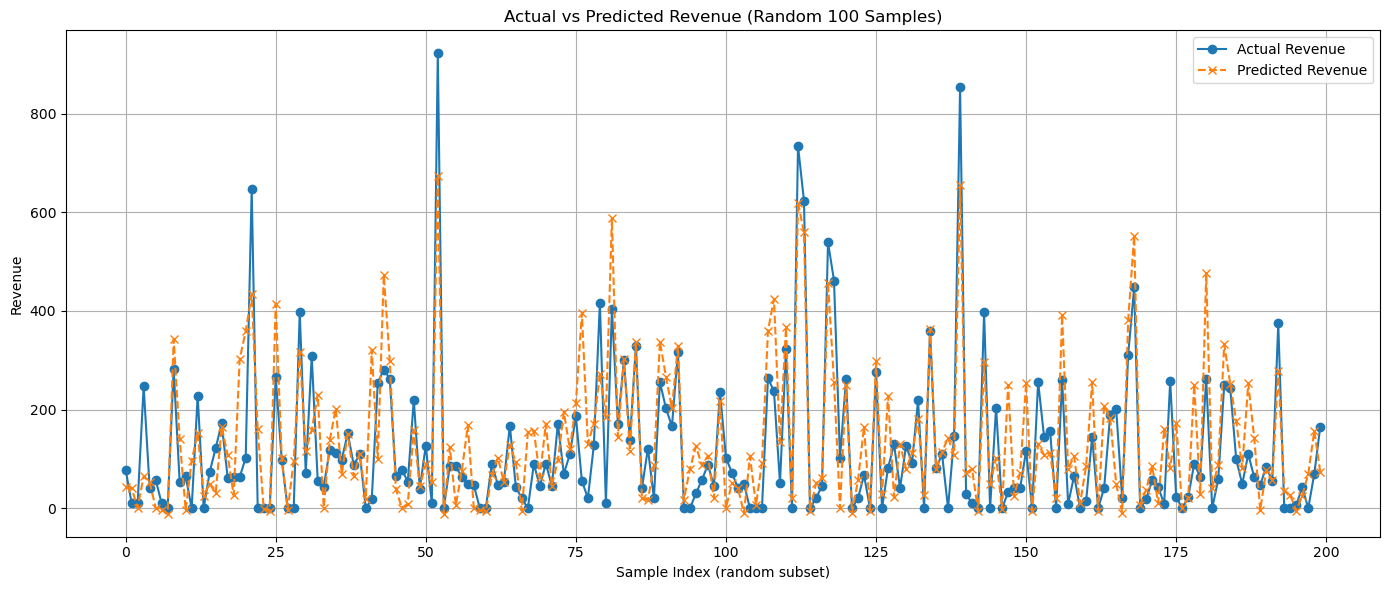

In [39]:
# 13) Plot Actual vs Predicted for 100 random samples
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Select 100 random indices from the validation set
sample_indices = np.random.choice(len(y_val), size=200, replace=False)

# Extract the actual and predicted values for these samples
actual_sample = y_val.values[sample_indices]
pred_sample   = y_pred[sample_indices]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_sample, label='Actual Revenue', marker='o')
plt.plot(pred_sample, label='Predicted Revenue', linestyle='--', marker='x')
plt.title("Actual vs Predicted Revenue (Random 100 Samples)")
plt.xlabel("Sample Index (random subset)")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


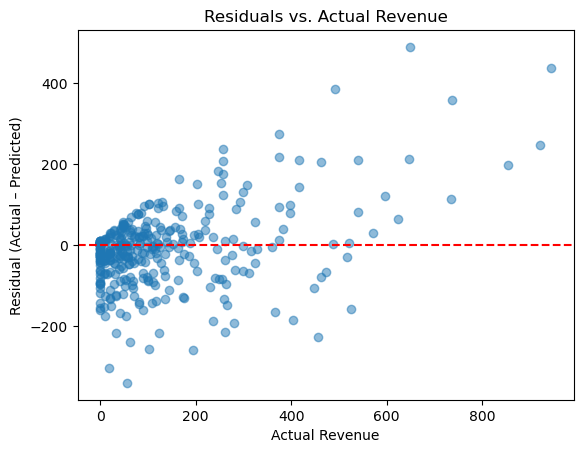

In [41]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred
plt.scatter(y_val, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Residual (Actual – Predicted)")
plt.title("Residuals vs. Actual Revenue")
plt.show()


In [ ]:
print(f"Missing features added: {missing_feats}")
print(f"Extra features dropped:  {extra_feats}")


### Inventory Main preprocessing

In [43]:
import pandas as pd

# Load the datasets
forecasting_df = pd.read_csv("my_validation_data_inventory.csv")
inventory_df = pd.read_excel("Cleaned_Merged_Inventory.xlsx", sheet_name='Sheet1')
# Drop columns not needed for forecasting
inventory_df = inventory_df.drop(columns=["VISTA Item", "Combo Item"])

# Drop the 'Year' column
# inventory_df = inventory_df.drop(columns=["Year"])

# Item classes we want to drop explicitly
drop_classes = [
    'VREWARDS', 'VREWARDS POINTS TRAN', 'VOUCHERS & SCREEN SA', 'PROMOTIONAL (GC)',
    'MODIFIERS', 'SUPPLEMENTARY ITEMS', 'GIFT CARDS', 'COMBO VOUCHERS',
    'DELIVERY', 'FUNCTION AND GROUP S'
]
# Drop those classes from the inventory
inventory_df = inventory_df[~inventory_df["Item Class"].isin(drop_classes)]



# Step 1: Aggregate item counts per class per session
item_counts = inventory_df.groupby(["Transaction Date", "Transaction Hour", "Item Class"])["No of Items"].sum().reset_index()

# Step 2: Pivot so each item class is a column
item_class_pivot = item_counts.pivot_table(
    index=["Transaction Date", "Transaction Hour"],
    columns="Item Class",
    values="No of Items",
    fill_value=0
).reset_index()

# Step 3: Calculate total session revenue (using Sell Price EA as already total)
revenue_per_session = inventory_df.groupby(["Transaction Date", "Transaction Hour"])["Sell Price EA"].sum().reset_index()

# Step 4: Merge item class counts with total revenue
final_inventory_summary = pd.merge(
    item_class_pivot,
    revenue_per_session,
    on=["Transaction Date", "Transaction Hour"],
    how="left"
)

# Step 5: Rename revenue column for clarity
final_inventory_summary = final_inventory_summary.rename(columns={"Sell Price EA": "Total Session Revenue"})

###############################################################
final_inventory_summary.to_csv("final_inventory_summary.csv", index=False)
################################################################


# Convert date columns to datetime if not already
forecasting_df["Session Date"] = pd.to_datetime(forecasting_df["Session Date"])
final_inventory_summary["Transaction Date"] = pd.to_datetime(final_inventory_summary["Transaction Date"])

# Now perform the merge
merged_df = forecasting_df.merge(
    final_inventory_summary,
    how="inner",
    left_on=["Session Date", "Session Hour"],
    right_on=["Transaction Date", "Transaction Hour"]
)

# Drop duplicate columns from right side
merged_df = merged_df.drop(columns=["Transaction Date", "Transaction Hour"])

########################################################################
merged_df.to_csv("basketanalysis.csv", index=False)
########################################################################

In [45]:
merged_df.columns

Index(['Session Date', 'Session Hour', 'Total Admits',
       'Lang_Chinese (Mandarin)', 'Lang_English', 'Lang_Hindi', 'Lang_Kannada',
       'Lang_Korean', 'Lang_Malayalam', 'Lang_Nepali', 'Lang_No Subtitles',
       'Lang_Punjabi', 'Lang_Spanish', 'Lang_Swedish', 'Lang_Tamil',
       'Lang_Telugu', 'Lang_Vietnamese', 'Genre_ACTION', 'Genre_ADVENTURE',
       'Genre_ANIMATION', 'Genre_BIOGRAPHY', 'Genre_COMEDY', 'Genre_CRIME',
       'Genre_DOCUMENTARY', 'Genre_DRAMA', 'Genre_FANTASY', 'Genre_HORROR',
       'Genre_ROMANCE', 'Genre_THRILLER', 'Rating_E', 'Rating_G', 'Rating_M',
       'Rating_MA15', 'Rating_PG', 'Rating_R18+', 'Duration_Short',
       'Duration_Medium', 'Duration_Long', 'Total Revenue', 'DayOfWeek',
       'Month', 'CONDIMENTS', 'CONFECTIONARY', 'DRINKS',
       'DRINKS - EXTRA LARGE', 'DRINKS - FLAVOUR SHO', 'DRINKS - GLASS',
       'DRINKS - HOT 8OZ', 'DRINKS - LARGE', 'DRINKS - LARGE (KIOS',
       'DRINKS - MEDIUM', 'DRINKS - NO ICE', 'DRINKS - PROMO',
       'DRI

In [47]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Load your validation data
df_val = pd.read_csv("basketanalysis.csv")  # <-- replace with your actual file

# 2) Load the trained model and column lists
model       = joblib.load("best_catboost_model_run3.pkl")
feature_cols = joblib.load("feature_cols_run3.pkl")
target_cols  = joblib.load("target_cols_run3.pkl")

# 3) Handle missing/extra columns in df_val

# 3a) Missing features
missing_feats = [f for f in feature_cols if f not in df_val.columns]
print(f"🔍 Missing features to ADD ({len(missing_feats)}): {missing_feats}")
for f in missing_feats:
    df_val[f] = 0

# 3b) Missing targets
missing_targets = [t for t in target_cols if t not in df_val.columns]
print(f"🔍 Missing target cols to ADD ({len(missing_targets)}): {missing_targets}")
for t in missing_targets:
    df_val[t] = 0

# 3c) Drop any extra columns beyond features+targets
allowed = set(feature_cols + target_cols)
extra = [c for c in df_val.columns if c not in allowed]
print(f"🗑️ Dropping extra columns ({len(extra)}): {extra}")
df_val.drop(columns=extra, inplace=True)

# 4) Split into X_val and y_val, ensuring correct order
X_val = df_val[feature_cols].copy()
y_val = df_val[target_cols].copy()

# 5) Predict
y_pred = model.predict(X_val)              # shape (n_samples, n_targets)
y_pred_df = pd.DataFrame(y_pred, columns=target_cols, index=df_val.index)

y_pred_df = y_pred_df.round().astype(int)


# 6) Evaluate per-item metrics
metrics = []
for col in target_cols:
    mae  = mean_absolute_error(y_val[col], y_pred_df[col])
    rmse = np.sqrt(mean_squared_error(y_val[col], y_pred_df[col]))
    r2   = r2_score(y_val[col], y_pred_df[col])
    metrics.append({
        "Item Class": col,
        "MAE":        mae,
        "RMSE":       rmse,
        "R²":         r2
    })
metrics_df = pd.DataFrame(metrics).set_index("Item Class")
print("\n📊 Validation metrics per item class:")
print(metrics_df)

# 7) (Optional) Overall aggregated metrics
overall = {
    "MAE":  metrics_df["MAE"].mean(),
    "RMSE": metrics_df["RMSE"].mean(),
    "R²":   metrics_df["R²"].mean()
}
print("\n🔗 Overall validation metrics:")
print(pd.Series(overall))


🔍 Missing features to ADD (19): ['Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Indonesian', 'Lang_Japanese', 'Lang_Maori', 'Lang_Not assigned', 'Lang_Thai', 'Lang_Urdu', 'Genre_FAMILY', 'Genre_GAMING', 'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_SCI-FI', 'Genre_TO BE ADVISED', 'Rating_CTC']
🔍 Missing target cols to ADD (0): []
🗑️ Dropping extra columns (21): ['Session Date', 'Lang_Spanish', 'Lang_Swedish', 'Total Revenue', 'CONDIMENTS', 'CONFECTIONARY', 'DRINKS - FLAVOUR SHO', 'DRINKS - GLASS', 'DRINKS - HOT 8OZ', 'DRINKS - LARGE (KIOS', 'DRINKS - PROMO', 'GOLD CLASS - LARGER', 'GOLD CLASS - SMALLER', 'GOLD CLASS - SWEETER', 'HANG BAGS', 'ICE CREAMS - SCOOP', 'PACKAGING', 'POPCORN - PROMO', 'PROMOTIONAL (TR)', 'SNACK - OTHER', 'UPSELL ITEMS']

📊 Validation metrics per item class:
                           MAE      RMSE        R²
Item Class                                        
SNACK - CHIPS         0.573574  0.993976

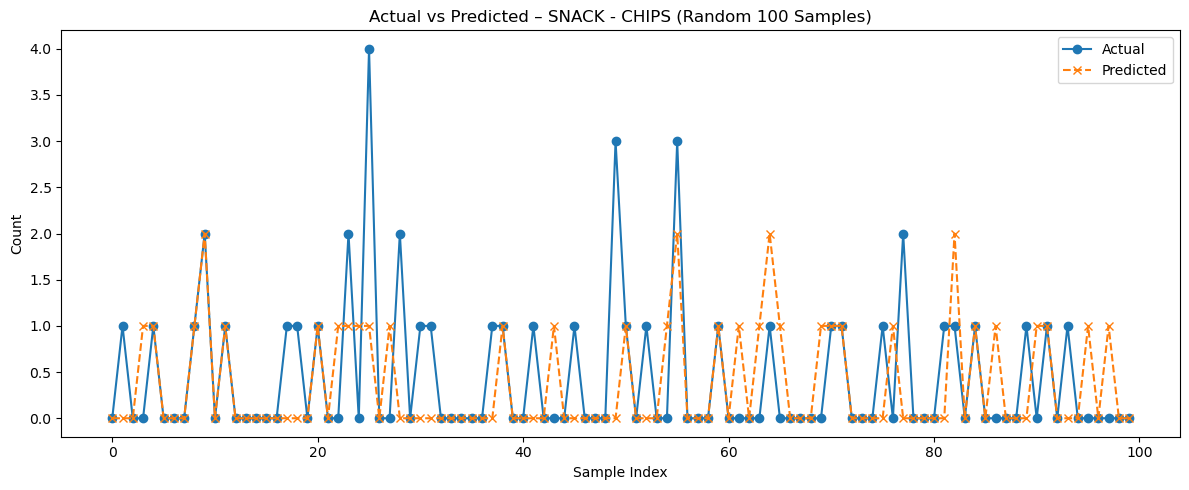

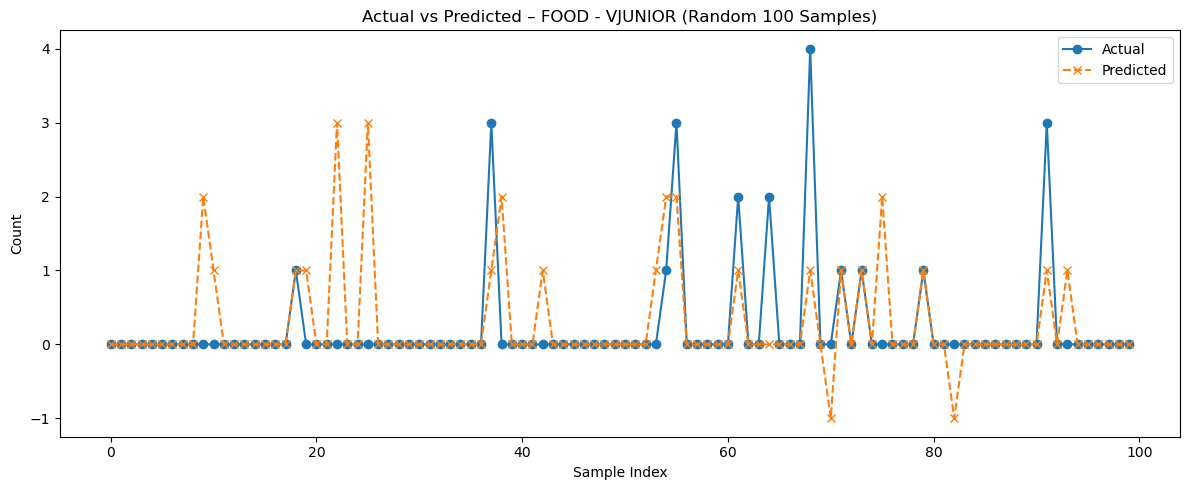

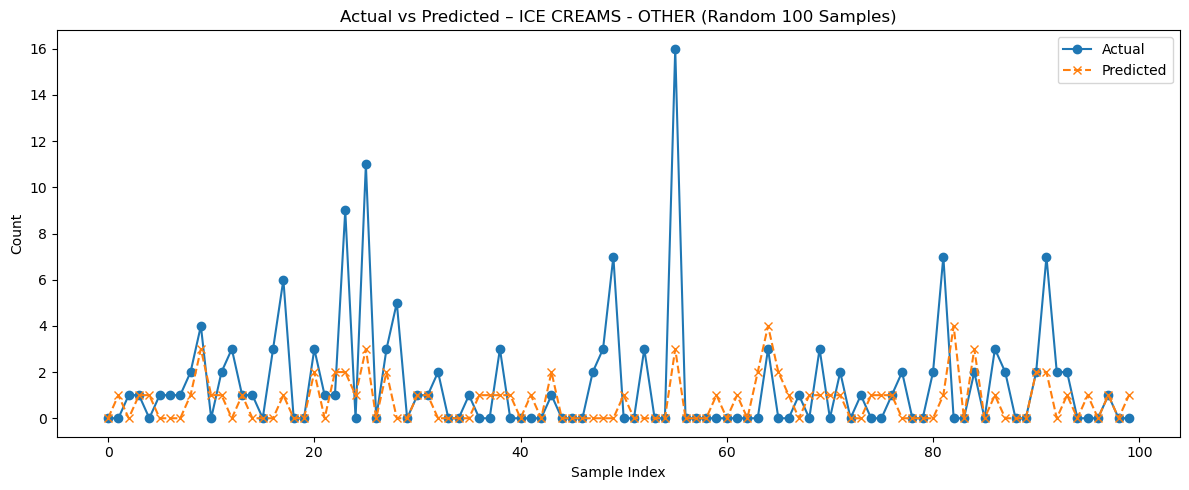

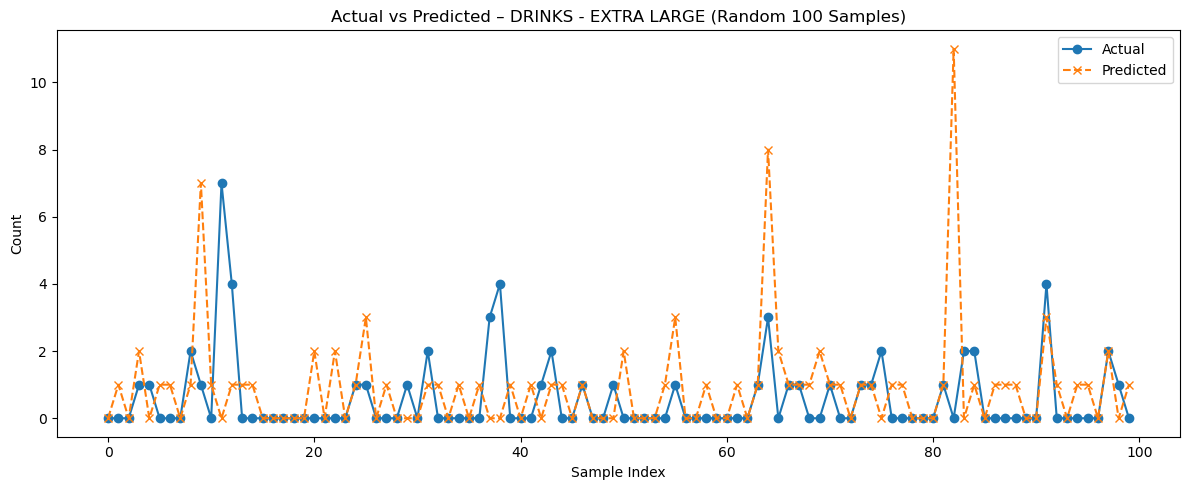

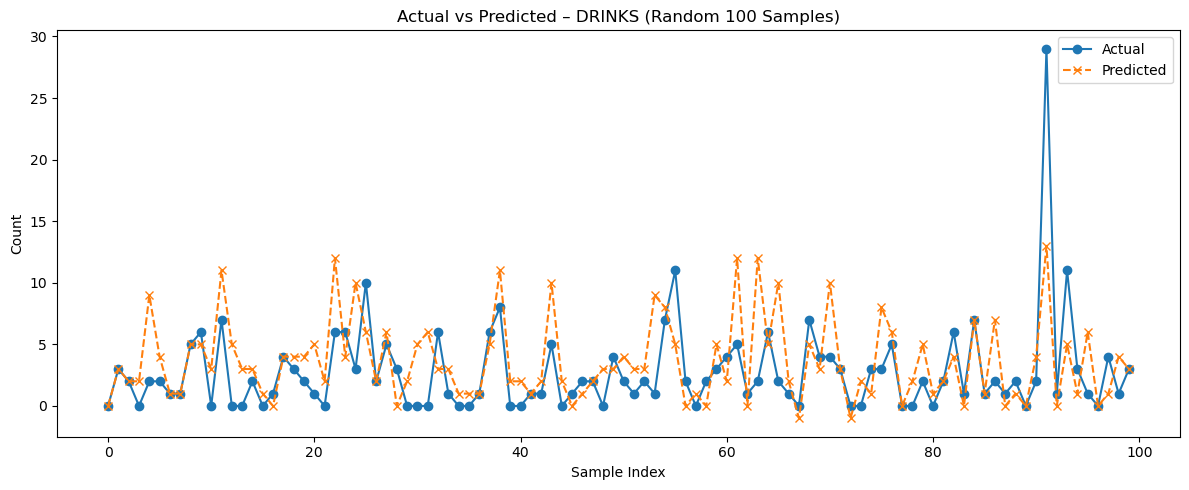

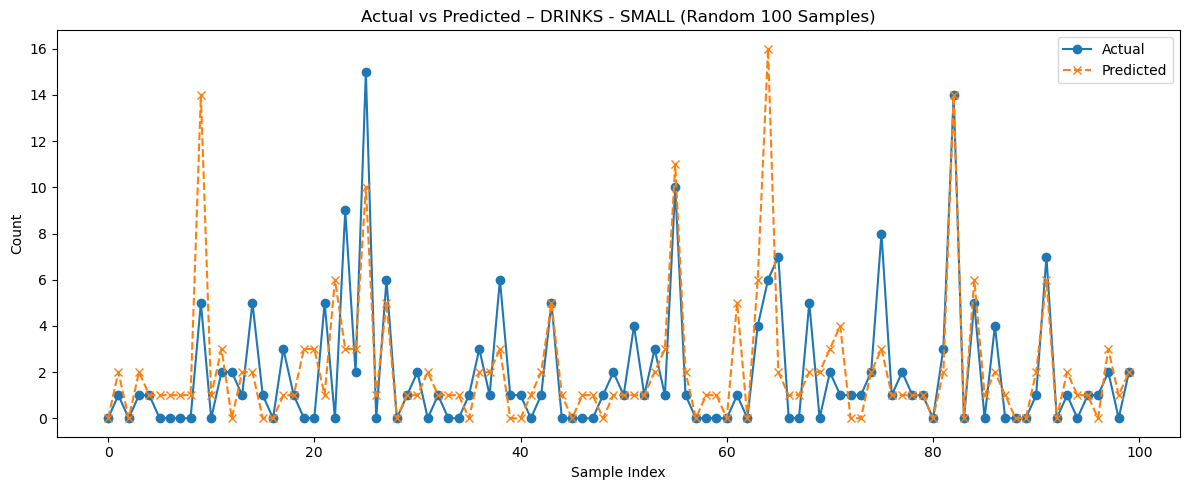

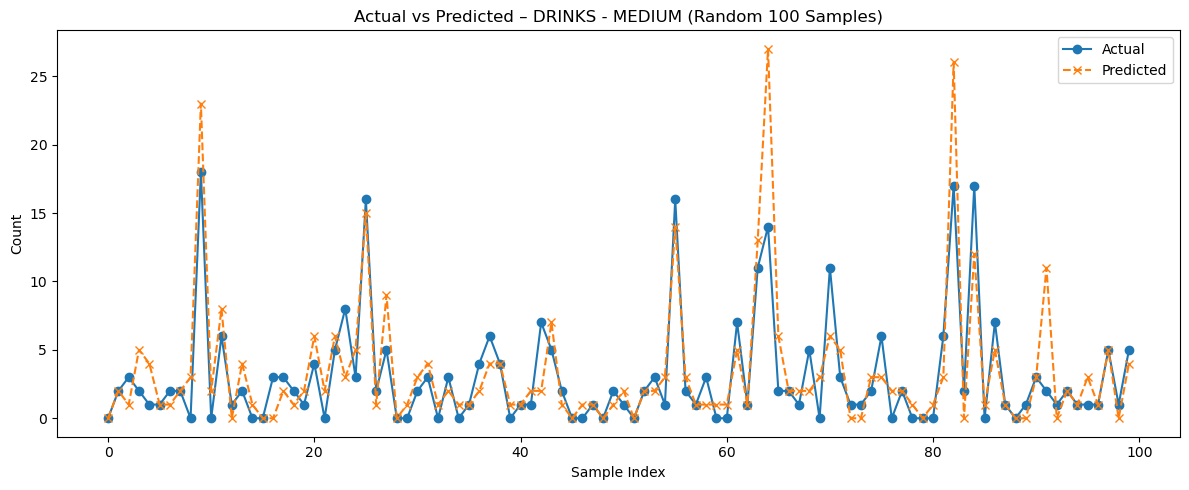

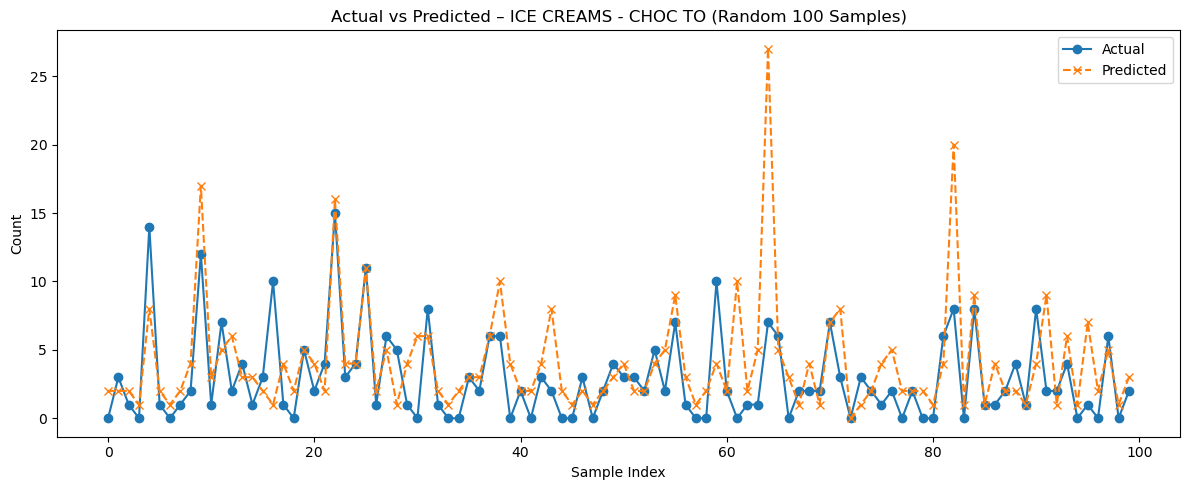

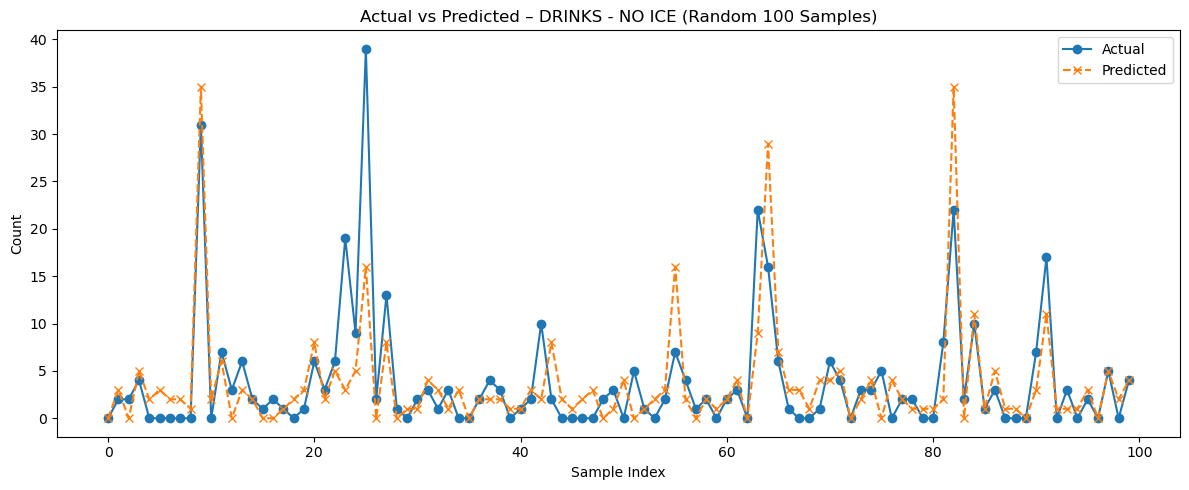

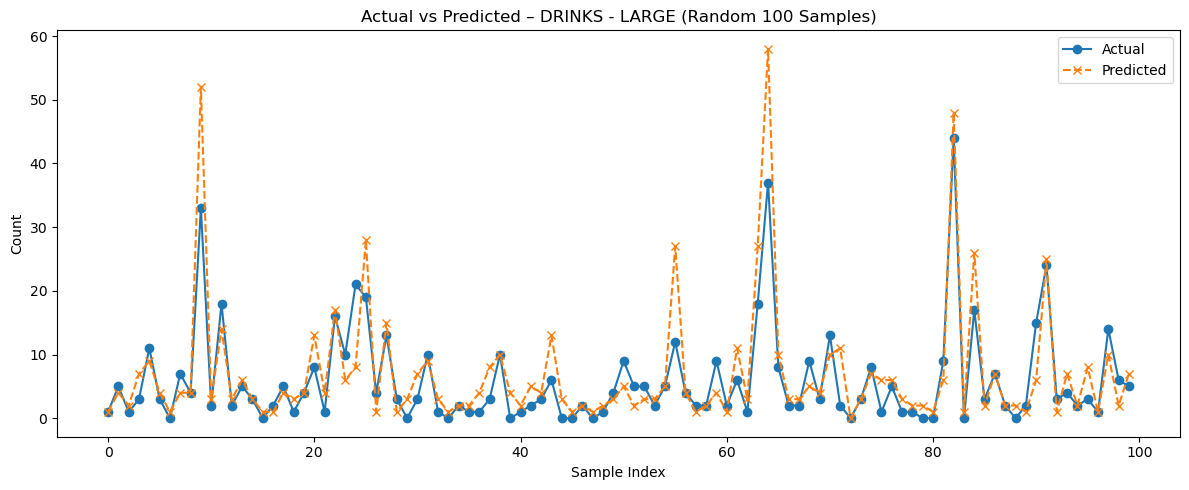

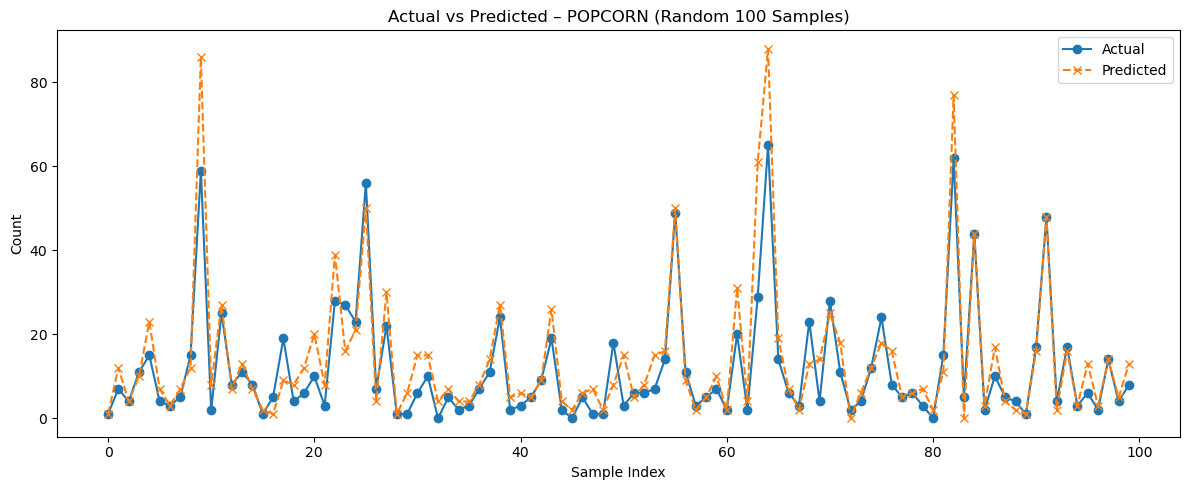

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Prepare your actual and predicted arrays
#    Make sure y_val, y_pred_df, and target_cols are defined from your validation script above.

# 2) Number of random samples to plot
n_samples = min(100, len(y_val))

# 3) Randomly pick row indices from the validation set
random_idx = np.random.choice(y_val.shape[0], size=n_samples, replace=False)

# 4) For each target class, plot actual vs. predicted over the sampled points
for col in target_cols:
    actual    = y_val[col].values[random_idx]
    predicted = y_pred_df[col].values[random_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(actual,    label='Actual',    marker='o')
    plt.plot(predicted, label='Predicted', linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted – {col} (Random {n_samples} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [51]:
# 8) Build and save Original vs. Predicted comparison
comparison_df = pd.concat(
    [y_val.add_suffix("_Actual"), y_pred_df.add_suffix("_Predicted")],
    axis=1
)

# 9) Persist to CSV
comparison_df.to_csv("validation_comparison_run3.csv", index=False)
print("✅ Saved original vs. predicted values to validation_comparison_run3.csv")

✅ Saved original vs. predicted values to validation_comparison_run3.csv
